In [241]:
%pylab inline
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table, vstack
import hdbscan
from pathlib import Path
import seaborn as sns
import glob
import json
%matplotlib inline
sns.set_color_codes()

Populating the interactive namespace from numpy and matplotlib


/home/luis/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['table', 'vstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [242]:
ROOT_PATH = Path("..") 

In [243]:
table = Table.read("Final-list-emitters-allparam-unique.ecsv", format="ascii.ecsv")

In [244]:
# Colors
m = (table["e_g_PStotal"] <= 0.2) & (table["e_i_PStotal"] <= 0.2) & (table["e_z_PStotal"] <= 0.2)
m1 =  (table["e_u_PStotal"] <= 0.2) &(table["e_g_PStotal"] <= 0.2) & (table["e_i_PStotal"] <= 0.2) 
zg = table['z_PStotal'][m] - table['g_PStotal'][m]
gr = table['g_PStotal'][m] - table['r_PStotal'][m]
ri = table['r_PStotal'][m] - table['i_PStotal'][m]
ug = table['u_PStotal'][m1] - table['g_PStotal'][m1]
gr_ = table['g_PStotal'][m1] - table['r_PStotal'][m1]
rz = table['r_PStotal'][m] - table['z_PStotal'][m]
rj0660 = table['r_PStotal'][m] - table['J0660_PStotal'][m]

In [245]:
X = np.array(list(zip(zg, gr)))
X.shape
# Standarized the data
X = StandardScaler().fit_transform(X)

# HAC

In [246]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
model.fit_predict(X)

array([2, 2, 1, ..., 4, 0, 1])

In [247]:
label_hi=model.labels_

In [248]:
table_= table[m]
table_["Label_hier"] = label_hi

In [249]:
#Masks
mask0 = table_["Label_hier"] == 0
mask1 = table_["Label_hier"] == 1
mask2 = table_["Label_hier"] == 2
mask3 = table_["Label_hier"] == 3
mask4 = table_["Label_hier"] == 4
mask5 = table_["Label_hier"] == 5

In [250]:
#creating colors
def color(mask):
    ri = table_['r_PStotal'][mask] - table_['i_PStotal'][mask]
    rj660 = table_['r_PStotal'][mask] - table_['J0660_PStotal'][mask]
    return ri, rj660

In [251]:
xc0, yc0 = color(mask0)
xc1, yc1 = color(mask1)
xc2, yc2 = color(mask2)
xc3, yc3 = color(mask3)
xc4, yc4 = color(mask4)
xc5, yc5 = color(mask5)

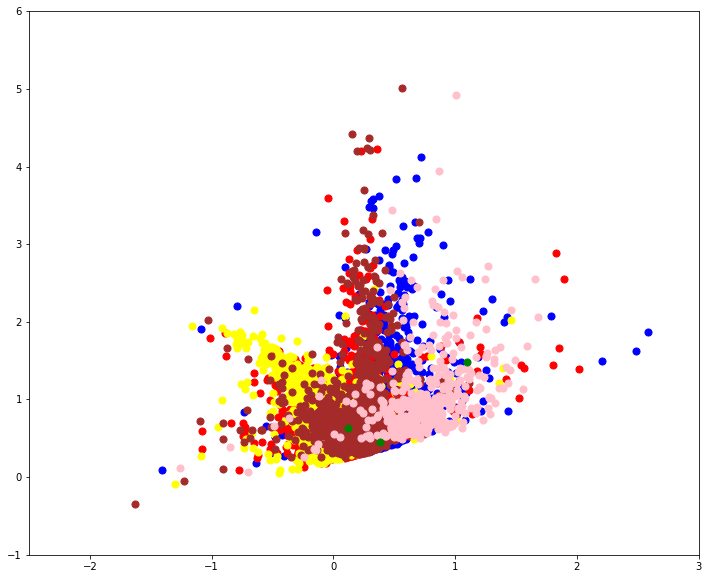

In [252]:
fig, ax1 = plt.subplots(figsize=(12, 10))
ax1.set(
      xlim=[-2.5, 3.],
      ylim=[-1.0, 6.])
ax1.scatter(xc0, yc0, c="blue",
            s=50, cmap='viridis');
ax1.scatter(xc1, yc1, c="red",
            s=50, cmap='viridis');
ax1.scatter(xc2, yc2, c="yellow",
            s=50, cmap='viridis');
ax1.scatter(xc3, yc3, c="brown",
            s=50, cmap='viridis');
ax1.scatter(xc4, yc4, c="pink",
            s=50, cmap='viridis');
ax1.scatter(xc5, yc5, c="green",
            s=50, cmap='viridis');

No handles with labels found to put in legend.


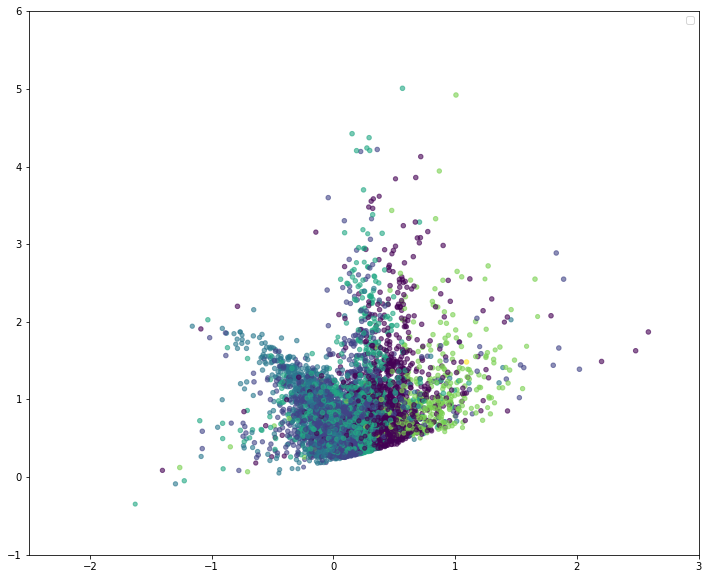

In [253]:
plt.figure(figsize=(12,10))
plt.axis([-2.5, 3., -1.0, 6.])
#plt.set(
      #xlim=[-2.5, 3.],
      #ylim=[-1.0, 6.])
plt.scatter(ri, rj0660, c=table_["Label_hier"], s=table_['r_PStotal'], alpha = 0.6)
plt.legend()

In [254]:
df = table_.to_pandas()
df["ri"]= ri
df["rj660"] = rj0660

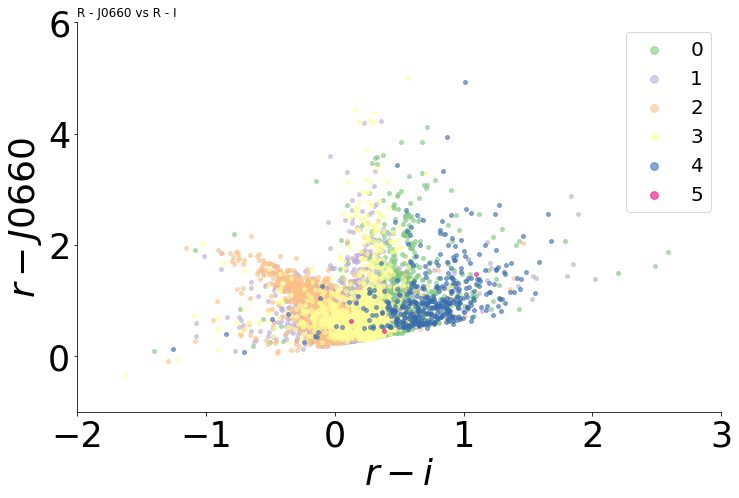

In [273]:
# Plot
sns.lmplot(x="ri", y="rj660", data=df, fit_reg=False, hue="Label_hier", legend=False, palette="Accent", scatter_kws={"alpha":0.6,"s":15} )
plt.axis([-2., 3., -1.0, 6.])
plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', labelsize=35)
# Legend
plt.legend(loc='upper right',  fontsize= 20, markerscale=2)
 
# titles
plt.xlabel(r'$r - i$', fontsize= 36)
plt.ylabel(r'$r - J0660$', fontsize= 36)
plt.title('R - J0660 vs R - I', loc='left')
plt.tight_layout()
gcf().set_size_inches(12,8)
plt.savefig("../paper/Figs/diagram-rixrj660.jpg")

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


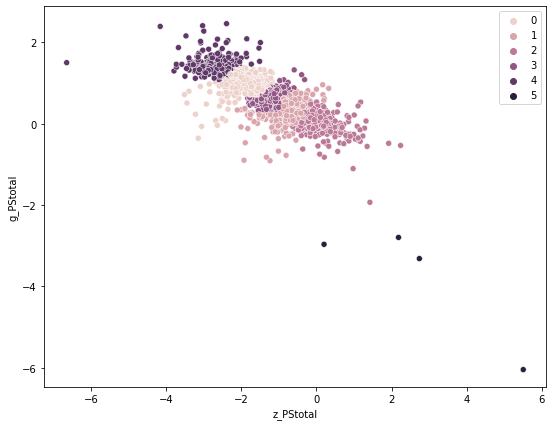

In [189]:
plt.figure(figsize=(9,7))
#plt.axis([-6.8, 2.5, -3., 5.])
sns.scatterplot(zg, gr, 
                hue=label_hi,)
                #palette=["blue","red", "green", "brown", "pink", "yellow"])

# Limiting the blue and red region
x_new = np.linspace(-15.0, 1000, 200)
y = 0.35*x_new + 1.5

#plt.plot(x_new, y, color='k', zorder=100, linestyle='-.')

# HDBSCAN

In [190]:
import hdbscan

In [191]:
# Applying HDBSCA1
clusterer = hdbscan.HDBSCAN(min_samples=20, min_cluster_size=50, prediction_data=True).fit(X)
labels_h = clusterer.labels_

In [192]:
clusterer.metric

'euclidean'

In [193]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_h)) - (1 if -1 in labels_h else 0)
n_cluster0 = list(labels_h).count(0)
n_cluster1 = list(labels_h).count(1)
n_cluster2 = list(labels_h).count(2)
n_noise_ = list(labels_h).count(-1)

In [194]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of cluster points 0: 4006
Estimated number of cluster points 1: 70
Estimated number of cluster points 2: 168
Estimated number of noise points: 2842


/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='z_PStotal', ylabel='g_PStotal'>

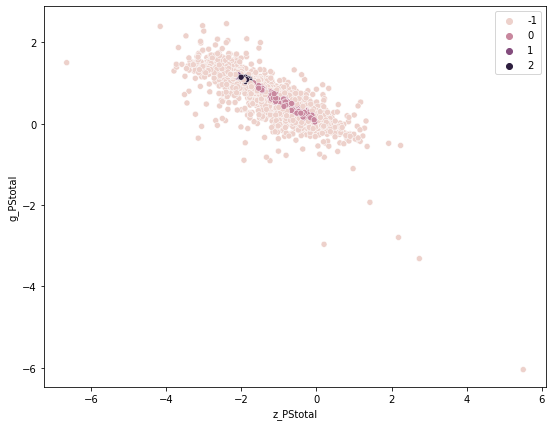

In [195]:
plt.figure(figsize=(9,7))
sns.scatterplot(zg, gr, 
                hue=labels_h,
                )